In [31]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
# pull the command from command.txt, if available
# pull the training scores from log.txt
# pull the evaluation scores from scores.txt

In [66]:
# shane's logs
filepath = '/home/shane/minerl/logs/shane_logs/'

# nico's logs
#filepath = '/home/shane/minerl/logs/nico_logs/nico_logs2/'

# bre's logs
#filepath = '/home/shane/minerl/logs/bre_logs/'

In [67]:
# df = pd.DataFrame(eval(s2)) problems with 'nan'
# df = pd.read_csv(f"{filepath}log.txt")
# readcsv doesnt work as lines are irregular. eval has problems b/c doesn't recognize nans
#import ast
#ast.literal_eval(s2) malformed ... try something else?

In [68]:
# shell command attempt
#log_file = f"{filepath}log.txt"
#stat_file = f"{filepath}statistics.txt"
#reward_file = f"{filepath}rewards.txt"
#! grep 'statistics:' {log_file} > {stat_file}
#! grep 'outdir:result' {log_file} > {reward_file}

In [69]:
rx_dict = {
    'statistics': re.compile(r"statistics:(?P<statistics>.*)\n"),
    'result': re.compile(r"outdir:result/.* (?P<result>step:(\d+) episode:(\d+) R:(.*))\n")
}
def _parse_line(line):
    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            #print(key)
            return key, match
    return None, None

In [70]:
statistics = []
rewards = []

with open(f"{filepath}log.txt", 'r') as f:
    for line in f:
        key, match = _parse_line(line)
        if key == 'statistics':
            # replace nan with 0
            stats = match.group('statistics').replace('nan', '0.0')
            # convert the list of tuples into a dict
            statistics.append(dict(eval(stats)))
            
        if key == 'result':
            result = match.group('result').replace('nan', '0.0').split()
            rewards.append(dict(map(lambda s : s.split(':'), result)))
            # the dict values are strings, should be int. convert here, or in dataframe?
            #print(step, episode, reward)
            
#print(rewards)
            
df = pd.DataFrame(rewards).apply(pd.to_numeric)
df_train = df.join(pd.DataFrame(statistics).set_index('cumulative_steps'), on='step')

In [75]:
df_train[:100]

,step,episode,R,average_q,average_loss,n_updates,rlen
0,2000,0,0.0,0.000000,0.000000,0,2000
1,4000,1,1.0,0.000000,0.000000,0,4000
2,6000,2,0.0,0.103058,0.141552,248,6000
3,8000,3,0.0,0.153867,0.112361,748,8000
4,10000,4,0.0,0.107413,0.104383,1248,10000
...,...,...,...,...,...,...,...
95,189474,95,12.0,0.348535,0.015226,46116,189474
96,191474,96,23.0,0.359949,0.021081,46616,191474
97,193474,97,14.0,0.364758,0.020032,47116,193474
98,195474,98,7.0,0.382235,0.019355,47616,195474


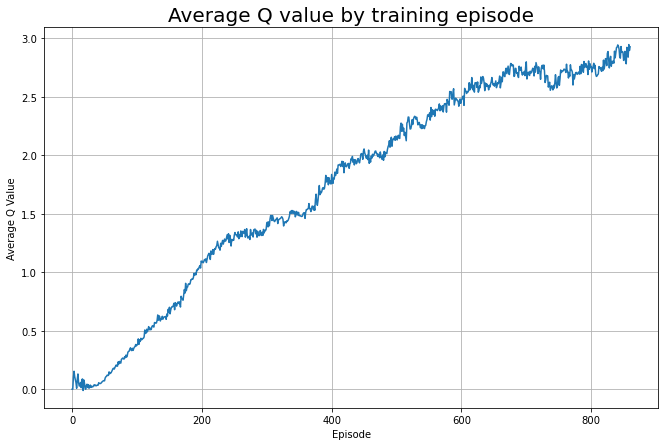

In [71]:
fig, ax = plt.subplots(figsize=(11,7))

ax.plot(df_train.episode, df_train.average_q, label = 'Average q value')
ax.set_title("Average Q value by training episode", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Average Q Value')
ax.grid()

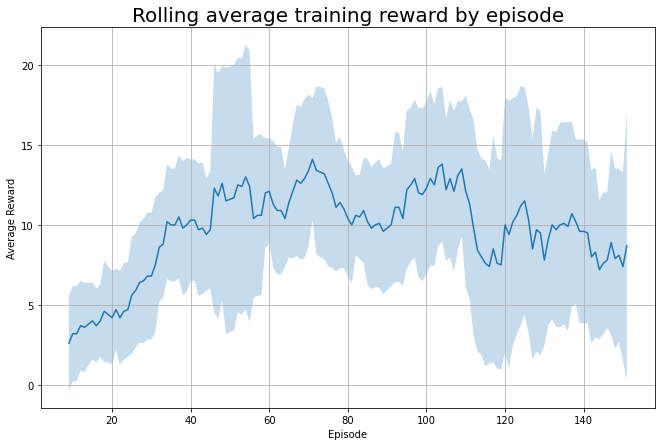

In [61]:
window = 10

mean = df_train['R'].rolling(window).mean()
sigma = df_train['R'].rolling(window).std()


fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df.episode, mean, label='Average reward')
ax.fill_between(df.episode, mean+sigma, mean-sigma, alpha=0.25)
ax.set_title("Rolling average training reward by episode", fontsize=20)
#ax.legend(loc='upper left')
ax.set_xlabel('Episode')
ax.set_ylabel('Average Reward')
ax.grid()

In [62]:
df_scores = pd.read_csv(f"{filepath}scores.txt", sep="\t")
# prepend with e_ to signify evaluation
df_scores.columns = ['e_'+s for s in list(df_scores.columns)]
df_joined = df_train.join(df_scores.set_index('e_steps'), on='step')

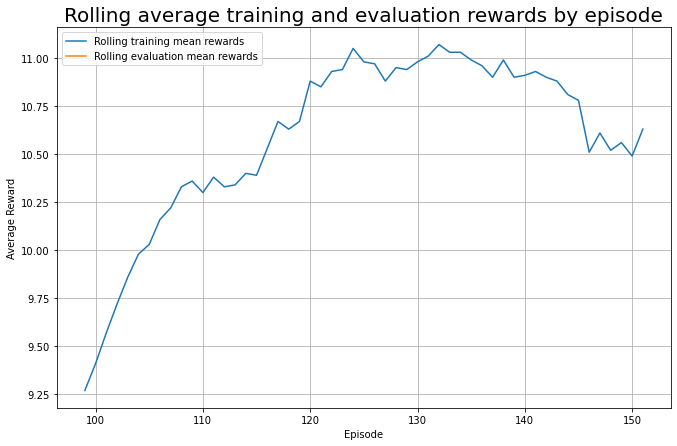

In [63]:
window = 100

train_mean = df_joined['R'].rolling(window).mean()
#one method, interpolate to skip over nans
eval_mean = df_joined['e_mean'].interpolate(method='linear').rolling(window).mean()

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df_joined.episode, train_mean, label = 'Rolling training mean rewards')
ax.plot(df_joined.episode, eval_mean, label = 'Rolling evaluation mean rewards')
ax.set_title("Rolling average training and evaluation rewards by episode", fontsize=20)
ax.legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Average Reward')
ax.grid()

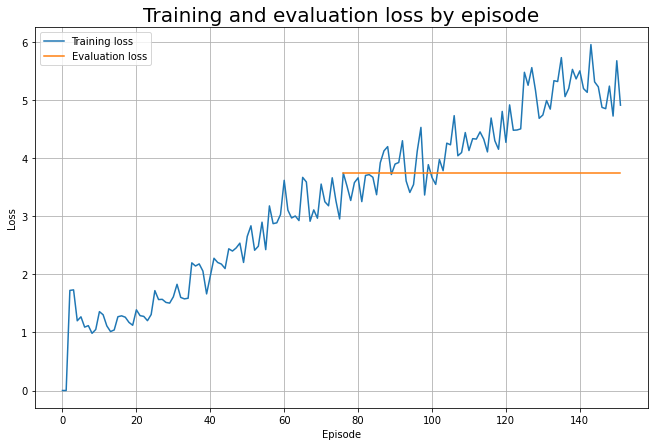

In [64]:
#method one, interpolation. I like this less
train_loss = df_joined['average_loss']
eval_loss = df_joined['e_average_loss'].interpolate(method='linear')

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df_joined.episode, train_loss, label = 'Training loss')
ax.plot(df_joined.episode, eval_loss, label = 'Evaluation loss')
ax.set_title("Training and evaluation loss by episode", fontsize=20)
ax.legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Loss')
ax.grid()

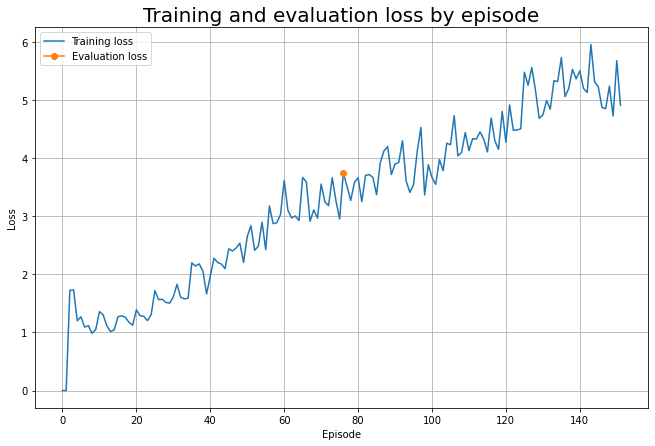

In [65]:
#method 2, plot with dots. I like this more

train_loss = df_joined['average_loss']
eval_loss = df_joined['e_average_loss']

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df_joined.episode, train_loss, label = 'Training loss')
ax.plot(df_joined.episode, eval_loss, 'o-', label = 'Evaluation loss')
ax.set_title("Training and evaluation loss by episode", fontsize=20)
ax.legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Loss')
ax.grid()

In [54]:
df_scores

,e_steps,e_episodes,e_elapsed,e_mean,e_median,e_stdev,e_max,e_min,e_average_q,e_average_loss,e_cumulative_steps,e_n_updates,e_rlen
0,151359,153,17929.546328,-14.276875,-16.605597,23.306074,27.145649,-51.026719,131.36403,1.912841,151359,36590,151359
1,300836,308,36825.814299,-24.645416,-21.171753,36.804569,26.639973,-96.306236,276.37677,4.910460,300836,73960,300000
2,450033,456,56030.610398,-0.476819,-6.456629,38.887919,144.680854,-39.142479,504.12363,7.457492,450033,111259,300000
3,601106,598,79717.889257,-9.344816,-7.980667,31.386551,50.282701,-67.118317,745.63885,12.086363,601106,149027,300000
4,750156,749,99309.454166,-22.893548,-10.307964,44.596432,30.906282,-127.931580,1087.81380,16.479201,750156,186290,300000
5,900838,902,119181.000124,-4.497449,-5.300489,31.617537,39.352953,-88.464684,2213.66380,38.337676,900838,223960,300000
